In [1]:
#################################################################################
# 
# Project fMRI - Resting state study
#
#################################################################################

In [2]:
###############################
# Installing required libraries
###############################
%matplotlib inline
!pip install boto3
import os
import boto3
from botocore.handlers import disable_signing
import re 
import numpy as np
client = boto3.client('s3')
client.meta.events.register('choose-signer.s3.*', disable_signing)

In [5]:
##########################################################
# Loading Resting State images found on AOMIC for ind 0001
##########################################################

# 1 - Filter the data to include resting state only

paginator = client.get_paginator('list_objects')

operation_parameters = {'Bucket': 'openneuro.org',
                        'Prefix': 'ds002790/derivatives/fmriprep/sub-0001/func'}

result = paginator.paginate(**operation_parameters)
filtered_iterator = result.search("Contents[?Key.contains(@,'task-restingstate')]")
task_list=[key_data['Key'] for key_data in filtered_iterator]

In [6]:
# 2 - Use Panda library to select our files

import pandas as pd

# Use Panda library to split files
files= np.array(task_list) #transform task list in np array np.array(task_list)
# Generate a list using split
filename_split = []
for i in files:
    filename_split.append(i[44:].split('_'))

# make a panda Data Frame with filename  pd.DataFrame( filename_split)[5]
pd_filename_list= pd.DataFrame(filename_split) 


In [7]:
# Run through all files with nii.gz endings
nii_task=np.array([x.endswith('nii.gz') for x in task_list]) 
nii_files=np.asarray(task_list)[nii_task]
pd.DataFrame([y.split("_") for y in pd.DataFrame([x.split("/") for x in  nii_files])[5] ])

,0,1,2,3,4,5
0,sub-0001,task-restingstate,acq-seq,space-MNI152NLin2009cAsym,boldref.nii.gz,None
1,sub-0001,task-restingstate,acq-seq,space-MNI152NLin2009cAsym,desc-aparcaseg,dseg.nii.gz
2,sub-0001,task-restingstate,acq-seq,space-MNI152NLin2009cAsym,desc-aseg,dseg.nii.gz
3,sub-0001,task-restingstate,acq-seq,space-MNI152NLin2009cAsym,desc-brain,mask.nii.gz
4,sub-0001,task-restingstate,acq-seq,space-MNI152NLin2009cAsym,desc-preproc,bold.nii.gz
5,sub-0001,task-restingstate,acq-seq,space-T1w,boldref.nii.gz,None
6,sub-0001,task-restingstate,acq-seq,space-T1w,desc-aparcaseg,dseg.nii.gz
7,sub-0001,task-restingstate,acq-seq,space-T1w,desc-aseg,dseg.nii.gz
8,sub-0001,task-restingstate,acq-seq,space-T1w,desc-brain,mask.nii.gz
9,sub-0001,task-restingstate,acq-seq,space-T1w,desc-preproc,bold.nii.gz


In [8]:

file_key=nii_files[4]


In [9]:
import os.path

# s3 client download_file
if not  os.path.exists( "resting.nii.gz"):
    client.download_file('openneuro.org', file_key, 'resting.nii.gz')

In [10]:
! pip install nilearn

In [11]:
from nilearn import plotting
from nilearn import image

/home/karkar/miniconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  
/home/karkar/miniconda3/envs/fmri/lib/python3.7/site-packages/nilearn/plotting/html_stat_map.py:217: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  bg_img = load_mni152_template()


(65, 77, 60, 480)



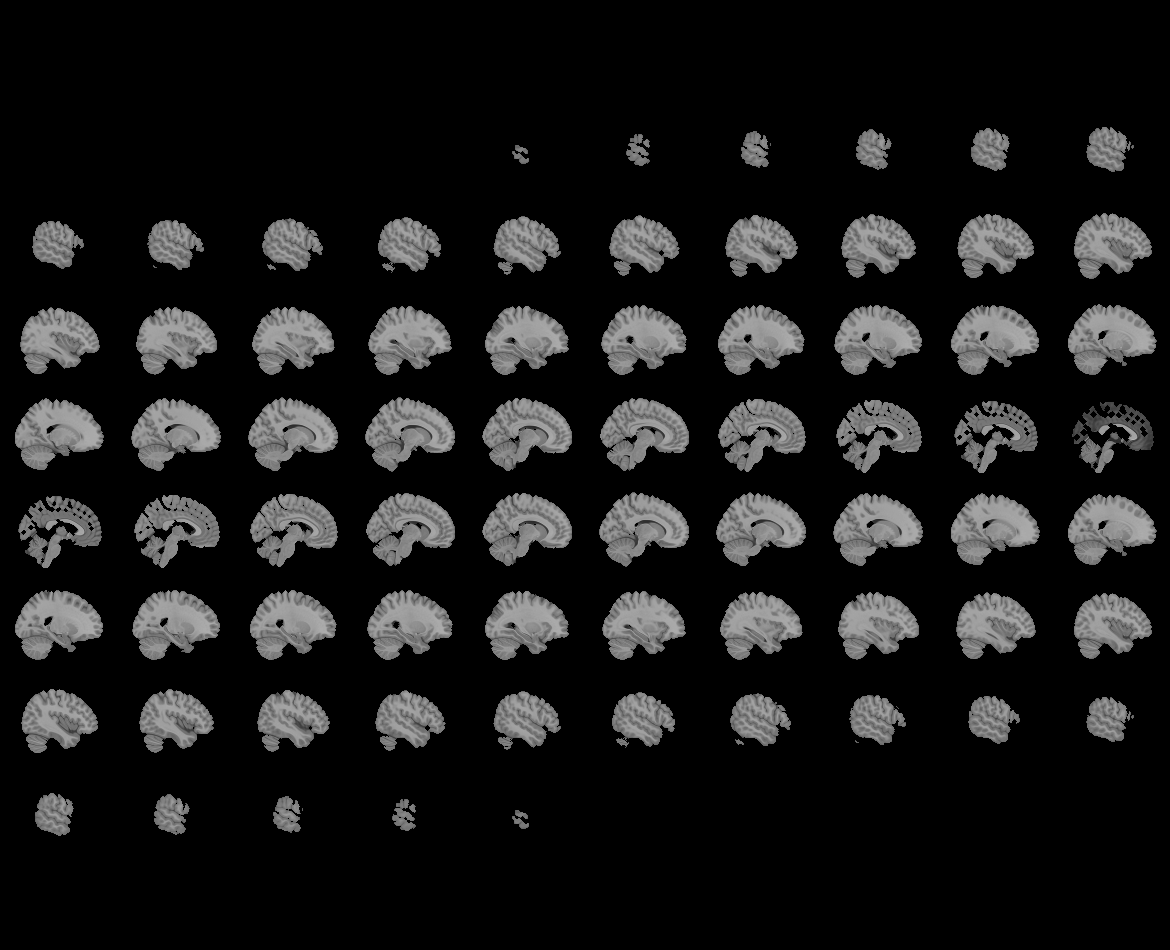
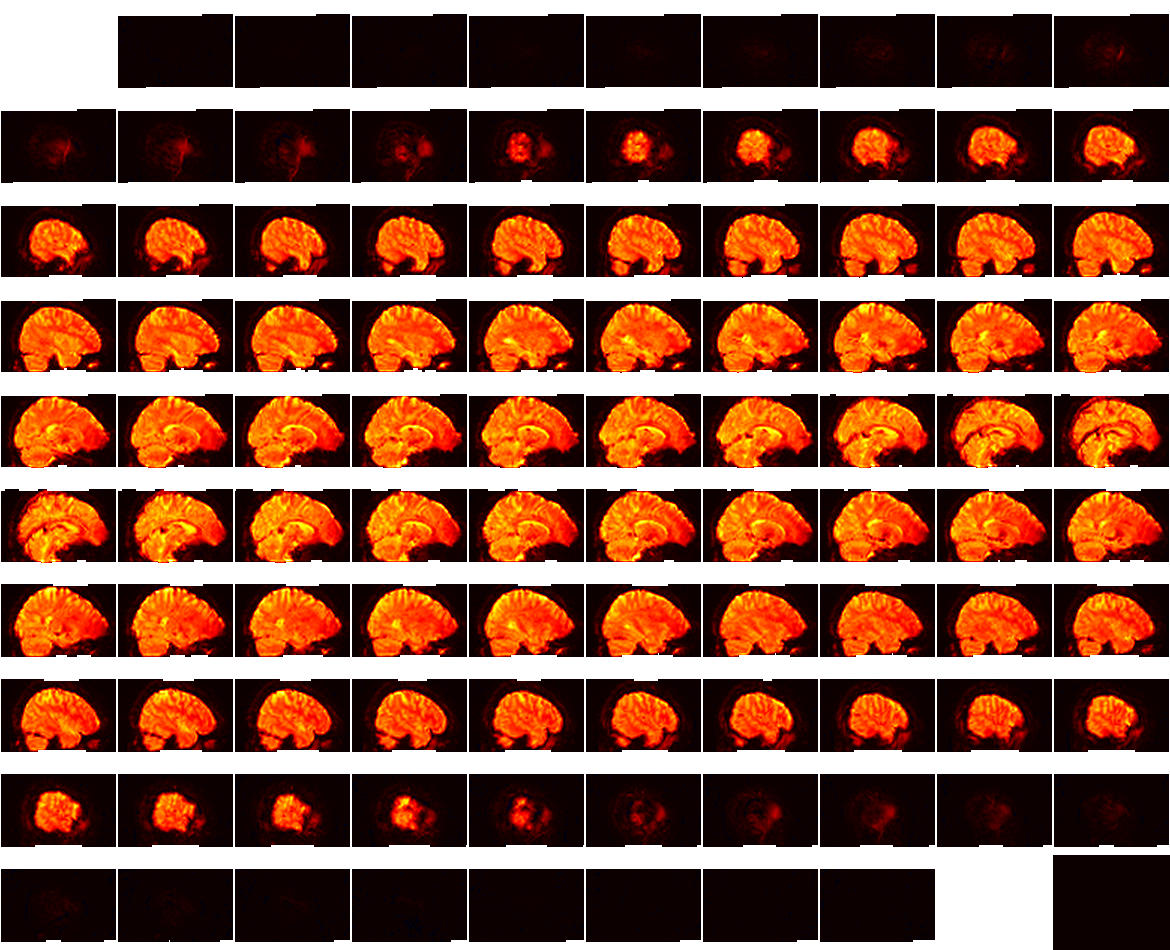

In [12]:
img= image.load_img('resting.nii.gz')  # load your image with image.load_img
print(img.get_data().shape)
# launch interactive 3d view with view_img function
plotting.view_img(image.index_img(img, 0))

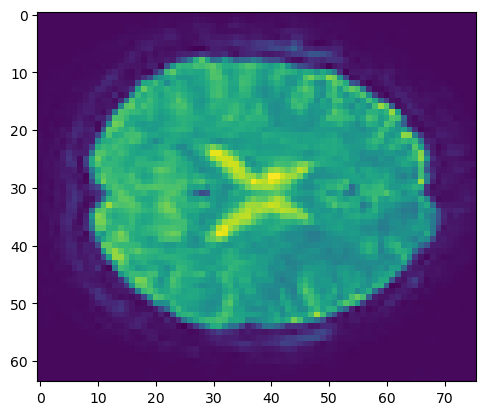

In [13]:
from matplotlib import pyplot as plt
volume= img.get_fdata() # extract voil;ume data from image
flat_slice=volume[1:,1:,30,0]
plt.imshow(flat_slice, interpolation='nearest')
plt.show()

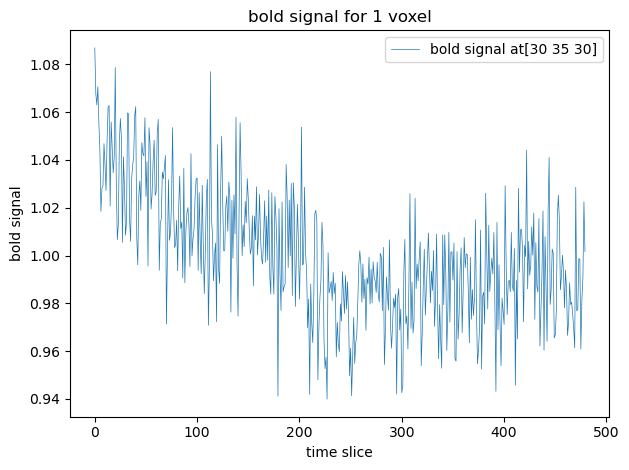

In [14]:
ts= volume[30,35,30,:] #extract one time serie
plt.plot(range(0,len(ts)), ts/ts.mean(), label='bold signal at'+np.array2string(np.array([30,35,30])), 
         linewidth=0.5)

# Add title and labels

plt.title('bold signal for 1 voxel')
plt.xlabel('time slice')
plt.ylabel('bold signal')

# Add legend

plt.legend()

# Auto space

plt.tight_layout()

# Display plot

plt.show() 

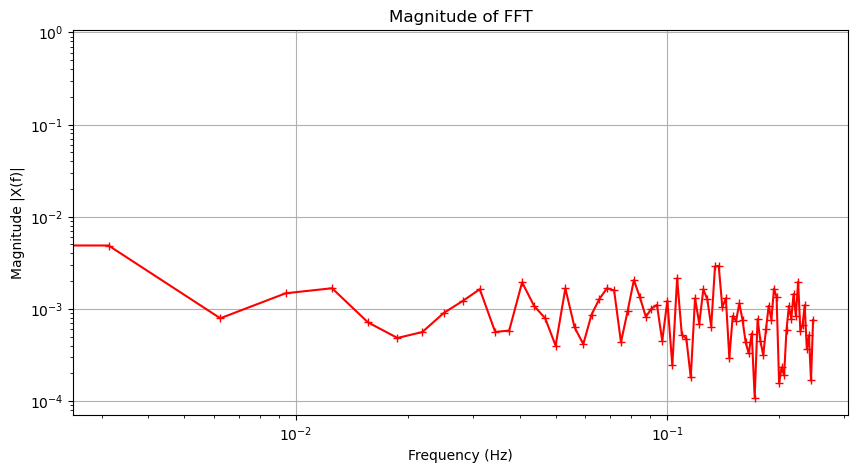

In [15]:
from scipy.fft import fft,fftfreq
from scipy.fftpack import fftshift

dt2 = 2#  use TR of the EPI acqisition
fs2 = 1/dt2 
# time vector
# Calculate the FFT
L =240# find out the number of acquisitions 
T2 = L*dt2 # duration, seconds

tv2 = np.linspace(0,1,L) # time vector in sec

NFFT = 160
Y_chirp = fft(ts/ts.mean() ,NFFT) # use the time serie normalized by its average 

fv2 = fftfreq(NFFT, dt2)[:NFFT//2] # make the frequency vector

plt.figure(figsize=(10,5))
plt.loglog(fv2,abs(Y_chirp[:NFFT//2])/(L),'r-+')
plt.title('Magnitude of FFT')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude |X(f)|')
#plt.xlim([0, 100])
plt.grid()
plt.show()

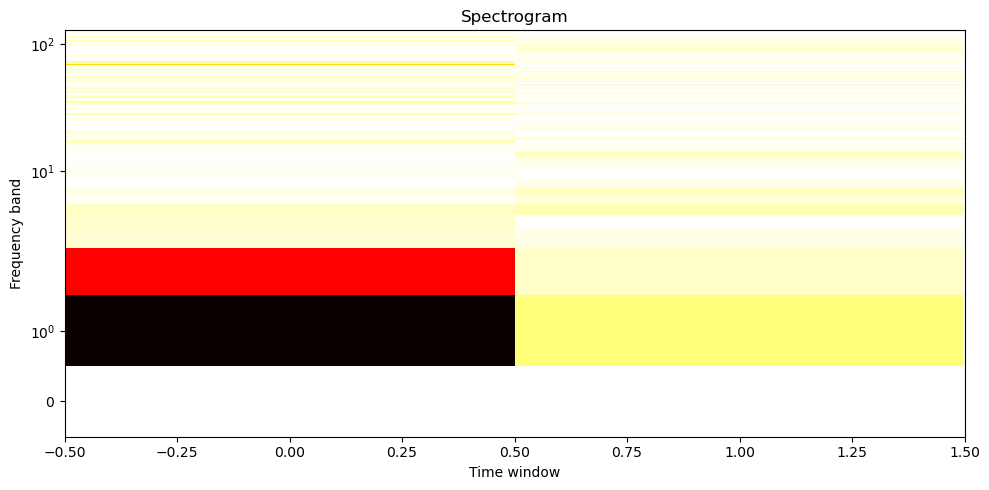

In [16]:
ts= volume[30,35,30,:] 
from scipy.signal import spectrogram
#plot windowed t/f analysis 
freqs, times, spectro = spectrogram( ts,fs=fs2) #, nperseg=int(ts.mean()))

plt.figure(figsize=(10, 5))
plt.imshow(spectro, aspect='auto', cmap='hot_r', origin='lower')
plt.title('Spectrogram')
plt.ylabel('Frequency band')
plt.xlabel('Time window')
plt.yscale('symlog')
plt.tight_layout()
plt.show()

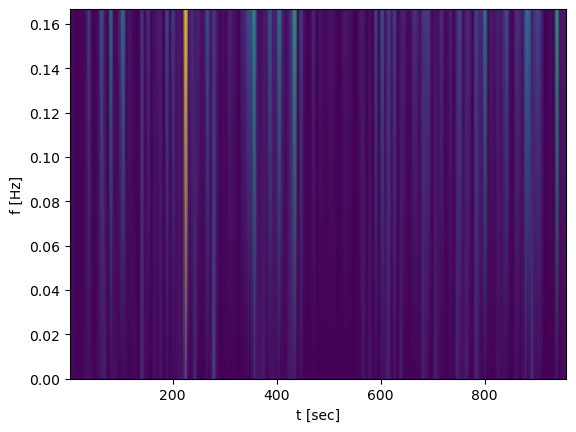

In [17]:
#plot windowed t/f analysis 
freqs, times, spectro = spectrogram( ts,fs=fs2, nperseg=3)
plt.pcolormesh(times, fftshift(freqs), fftshift(spectro, axes=0), shading='gouraud')
plt.ylabel('f [Hz]')
plt.xlabel('t [sec]')
#plt.yscale('symlog')
plt.show()

/home/karkar/miniconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


(65, 77, 60)


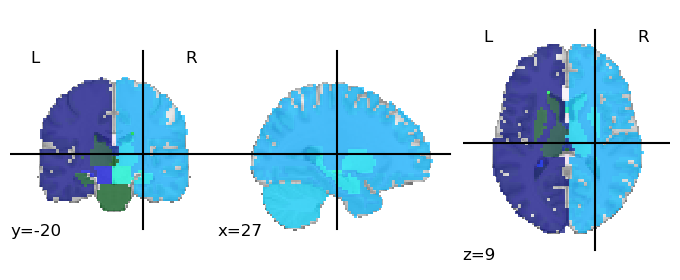

In [18]:
### Delete your seg file and rerun this cell
###############################################
import matplotlib as plt
file_key= nii_files[2] # find which image is the mask of regions
####### your seg file was wrong
if not  os.path.exists( "my.nii_seg.nii.gz"): 
    client.download_file("openneuro.org", file_key, "my.nii_seg.nii.gz")


img_seg=image.load_img("my.nii_seg.nii.gz")
print(img_seg.get_data().shape)
plotting.plot_roi((img_seg))#, threshold=None, cmap=plt.cm.prism)

/home/karkar/miniconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  This is separate from the ipykernel package so we can avoid doing imports until
/home/karkar/miniconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """
/home/karkar/miniconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: get_data() is

1331836.0


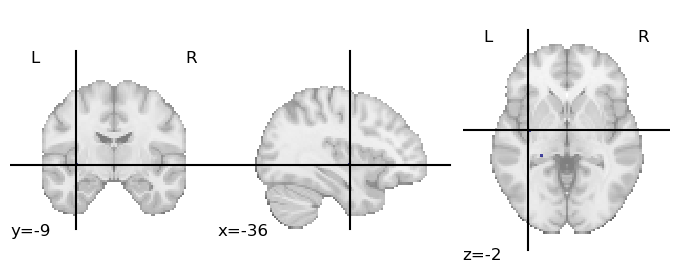

In [20]:
from nilearn.masking import apply_mask
import nibabel as nb
img_segbool=np.array(img_seg.get_data())
print(np.sum(img_segbool))
mask1=np.where(img_seg.get_data()==10)

mask2=np.where(img_seg.get_data()==12)
img_segbool[:]=0
img_segbool[mask1[0][0],mask1[1][0],mask1[2][0]]=1
img_segbool[mask2[0][0],mask2[1][0],mask2[2][0]]=1


#img_segbool[0:,0:,0:]=0
img_segbool.shape
np.sum(img_segbool)
nii_img_seg=nb.Nifti1Image(img_segbool, affine=img_seg.affine)
plotting.plot_roi(nii_img_seg)

In [28]:

masked_data = apply_mask(imgs=img, 
                         mask_img= nii_img_seg)


# masked_data shape is (timepoints, voxels).


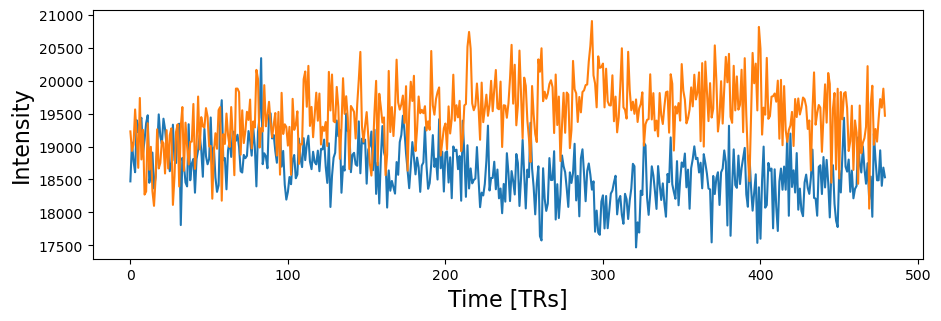

In [29]:
# And now plot two time series
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 3))
plt.plot(masked_data[:, :2])
plt.xlabel('Time [TRs]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
#plt.xlim(0, 150)
plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

plt.show()

In [ ]:
### removing complex signal drift 
#choose a time serie as example : 
ts = ...
# a / fit a 4 degree polynome -- or a low frequency cosine
# for a polynome
# find a0, a, b, c, d that fit the signal y= a0 + ax + bx² +cx³ +dx⁴
# you can use the code used in the filtering exercice 
# with optimize.curve_fit and a test_func 
# or use numpy.polyfit
# for low frequency cosine, use very low (<0.01) frequecy
#for starting parameters optimize.curve_fit  

drift = ....

# b/ remove the fitted drift from the signa
yf=ts-drift


In [ ]:
#plotting the whole process
t = time_vec
y=ts
plt.figure(figsize=(14,10))

# plot signal and the fitted drift
ax2=plt.subplot(411)
plt.plot(t, y, 'b-', label='signal')
plt.plot(t,drift, 'g--', label='drift')
plt.ylabel('bold signal')
plt.legend()
plt.grid()

# plot  sprectrogram for original signal 
freqs, times, spectro = spectrogram( y,fs=1/dt, nperseg=3)
plt.subplot(412, sharex=ax2)
plt.pcolormesh(times, fftshift(freqs), fftshift(spectro, axes=0), shading='gouraud')
plt.ylabel('f [Hz]')
plt.legend()

# plot old and new signal (centerd on the mean)
plt.subplot(413, sharex=ax2)
plt.plot(np.array(range(0,len(ts)))*dt, y-y.mean(), label='old bold signal', linewidth=0.5)
plt.plot(np.array(range(0,len(ts)))*dt, yf-yf.mean(), label='new voxel bold signal', linewidth=2)
plt.legend()

# plot  sprectrogram for new signal 
freqs, times, spectro = spectrogram( yf,fs=1/dt, nperseg=3)
plt.subplot(414, sharex=ax2)
plt.pcolormesh(times, fftshift(freqs), fftshift(spectro, axes=0), shading='gouraud')
plt.ylabel('f [Hz]')
plt.xlabel('t [sec]')
plt.legend()

# Auto space
plt.tight_layout()

# Display plot
plt.show()

In [ ]:

# Make a high pass filter with the code use in the filtering exercice 
fc = 0.01  # desired cutoff frequency of the filter, Hz
....
# Plot the frequency response ( the code use in the filtering exercice)
...
# calculate the FFT of the original signal and plot the frequency components (the code use in the filtering exercice)
...
# apply the filter to the signal obtained after drift removal (the code use in the filtering exercice)
...
# plot both the original and filtered signals (the code use in the filtering exercice)
...
# calculate the FFT of the filtered signal and plot the frequency components (the code use in the filtering exercice)
...
# plot spectrogram (the code use in the previous cell )  before and after filtering

In [ ]:
# Make a low pass filter  with the code use in the filtering exercice
fc = 0.15 
# Plot the frequency response ( the code use in the filtering exercice)
...
# calculate the FFT of the original signal and plot the frequency components (the code use in the filtering exercice)
...
# apply the filter to the signal obtained after drift removal (the code use in the filtering exercice)
...
# plot both the original and filtered signals (the code use in the filtering exercice)
...
# calculate the FFT of the filtered signal and plot the frequency components (the code use in the filtering exercice)
...
# plot spectrogram (the code use in the previous cell )  before and after filtering

In [ ]:

# repeat the filterinfg (drift + 2 filters) for another time serie
# and propose a measure of correlation based ond frequecy specrtum  

In [ ]:
# extend to cross-region analysis